共包含 4823 条有效地震记录

1.1 地震死亡人数最多的前10个国家
20    CHINA           2082195      37.21          
100   TURKEY          801154       14.32          
47    IRAN            664598       11.88          
42    HAITI           323484       5.78           
50    ITALY           308891       5.52           
52    JAPAN           232275       4.15           
73    PAKISTAN        143711       2.57           
30    ECUADOR         130485       2.33           
101   TURKMENISTAN    112412       2.01           
8     AZERBAIJAN      89251        1.6            

全球地震总死亡人数：5595400
前10国家死亡人数占比：87.37%



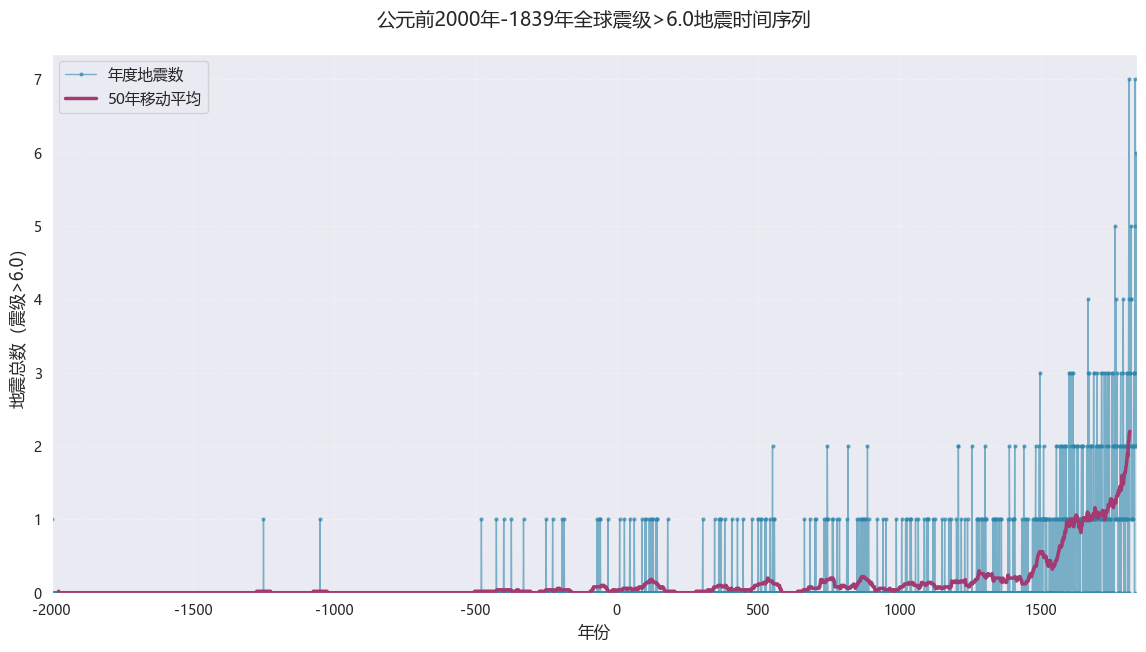

1.2 全球震级>6.0地震趋势分析
统计时间范围：公元前2000年-1839年
总地震次数：542次
年均地震次数：0.14次
地震最多年份：1812年（7次）
1.3 各国地震统计（地震总次数降序排列）
排名    国家              地震总数         最大地震震级          最大地震日期         
7     CHINA           592          8.5             1668.0-07-25   
20    JAPAN           361          9.1             2011.0-03-11   
48    INDONESIA       340          9.1             2004.0-12-26   
5     IRAN            263          7.9             856.0-12-22    
51    USA             229          9.2             1964.0-03-28   
14    TURKEY          224          7.8             1939.0-12-26   
4     GREECE          181          8.0             365.0-07-21    
27    PERU            157          8.8             1716.0-02-06   
34    CHILE           148          9.5             1960.0-05-22   
8     RUSSIA          148          9.0             1952.0-11-04   
37    MEXICO          144          8.6             1787.0-03-28   
42    PHILIPPINES     142          8.7             1897.0-09-21   
15    ITALY           105

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message="Glyph 8722 (\\N{MINUS SIGN}) missing from font\\(s\\)")

def load_earthquake_data(file_path):
    """
    读取地震TSV数据并预处理：
    1. 处理分隔符与编码
    2. 清理关键列缺失值
    3. 标准化数值列
    4. 组合日期
    """
    df = pd.read_csv(file_path, sep="\t",encoding="utf-8",na_values=["", "NA"],keep_default_na=True)
    df = df.dropna(subset=["Country", "Mag"])
    df["Mag"] = pd.to_numeric(df["Mag"], errors="coerce")  # 震级无效值转为NaN
    df["Deaths"] = pd.to_numeric(df["Deaths"], errors="coerce").fillna(0)  # 死亡人数缺失→0
    df = df.dropna(subset=["Mag"])
    # 3. 组合日期（Year+Mo+Dy→YYYY-MM-DD，空月/日填充为01）
    df["Mo"] = df["Mo"].apply(lambda x: str(int(x)) if pd.notna(x) and x != "" else "01")
    df["Dy"] = df["Dy"].apply(lambda x: str(int(x)) if pd.notna(x) and x != "" else "01")
    df["Combined_Date"] = (
        df["Year"].astype(str) + "-" +
        df["Mo"].str.zfill(2) + "-" +
        df["Dy"].str.zfill(2)
    )
    return df
Sig_Eqs = load_earthquake_data("earthquakes-2025-11-04_14-42-54_+0800.tsv")
print(f"共包含 {len(Sig_Eqs)} 条有效地震记录\n")


def top10_countries_by_deaths(df):
    """
    统计各国地震总死亡人数，输出前10名：
    """
    death_stats = df[df["Deaths"] > 0].groupby("Country")["Deaths"].sum().reset_index()
    top10_deaths = death_stats.sort_values(by="Deaths", ascending=False).head(10)
    global_total_deaths = df["Deaths"].sum()
    top10_deaths["Death_Ratio(%)"] = (top10_deaths["Deaths"] / global_total_deaths * 100).round(2)
    top10_deaths["Deaths"] = top10_deaths["Deaths"].astype(int)

    print("1.1 地震死亡人数最多的前10个国家")
    for idx, row in top10_deaths.iterrows():
        print(f"{idx+1:<5} {row['Country']:<15} {row['Deaths']:<12} {row['Death_Ratio(%)']:<15}")
    print(f"\n全球地震总死亡人数：{int(global_total_deaths)}")
    print(f"前10国家死亡人数占比：{top10_deaths['Death_Ratio(%)'].sum():.2f}%\n")
    return top10_deaths
top10_deaths_result = top10_countries_by_deaths(Sig_Eqs)


# ---------------------- 1.2 全球震级>6.0地震时间序列 ----------------------
def eq_above_6_time_series(df, start_year=-2000, end_year=1839):
    """
    按年份统计震级>6.0的地震总数，绘制时间序列图
    """
    eq_filtered = df[
        (df["Mag"] > 6.0) &
        (df["Year"] >= start_year) &
        (df["Year"] <= end_year)
    ]
    year_range = pd.DataFrame({"Year": range(start_year, end_year + 1)})
    eq_yearly_count = eq_filtered.groupby("Year")["Mag"].count().reset_index(name="Eq_Count")
    eq_time_series = year_range.merge(eq_yearly_count, on="Year", how="left").fillna(0)
    eq_time_series["Eq_Count"] = eq_time_series["Eq_Count"].astype(int)  # 计数转为整数
    eq_time_series["MA_50"] = eq_time_series["Eq_Count"].rolling(window=50, center=True).mean()

    plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "DejaVu Sans"]
    plt.rcParams["axes.unicode_minus"] = False
    plt.figure(figsize=(14, 7))

    plt.plot(
        eq_time_series["Year"], eq_time_series["Eq_Count"],
        color="#2E86AB", linewidth=1, marker="o", markersize=2, alpha=0.6, label="年度地震数"
    )

    plt.plot(
        eq_time_series["Year"], eq_time_series["MA_50"],
        color="#A23B72", linewidth=2.5, label="50年移动平均"
    )

    plt.xlabel("年份", fontsize=12)
    plt.ylabel("地震总数（震级>6.0）", fontsize=12)
    plt.title(f"公元前{abs(start_year)}年-1839年全球震级>6.0地震时间序列", fontsize=14, pad=20)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3, linestyle="--")
    plt.xlim(start_year, end_year)
    plt.ylim(bottom=0)
    plt.show()

    print("1.2 全球震级>6.0地震趋势分析")
    print(f"统计时间范围：公元前{abs(start_year)}年-1839年")
    print(f"总地震次数：{eq_time_series['Eq_Count'].sum()}次")
    print(f"年均地震次数：{eq_time_series['Eq_Count'].mean():.2f}次")
    print(f"地震最多年份：{eq_time_series.loc[eq_time_series['Eq_Count'].idxmax(), 'Year']}年（{eq_time_series['Eq_Count'].max()}次）")
    return eq_time_series
eq_6_time_series_result = eq_above_6_time_series(Sig_Eqs)



# ---------------------- 1.3 函数CountEq_LargestEq+各国统计（按地震总数降序） ----------------------
def CountEq_LargestEq(df, country):
    country_df = df[df["Country"].str.strip() == country.strip()]
    total_eq = len(country_df)

    if total_eq == 0:
        return total_eq, "无记录", "无记录"

    largest_eq = country_df.sort_values(by="Mag", ascending=False).iloc[0]
    largest_eq_date = largest_eq["Combined_Date"]  # 组合日期
    largest_eq_mag = round(largest_eq["Mag"], 1)  # 最大震级（保留1位小数）

    return total_eq, largest_eq_date, largest_eq_mag

def country_earthquake_summary(df):
    unique_countries = df["Country"].unique()
    unique_countries = [c for c in unique_countries if pd.notna(c) and c.strip() != ""]
    # 批量统计每个国家
    country_summary = []
    for country in unique_countries:
        total_eq, largest_date, largest_mag = CountEq_LargestEq(df, country)
        country_summary.append({
            "Country": country,
            "Total_Earthquakes": total_eq,
            "Largest_Earthquake_Mag": largest_mag,
            "Largest_Earthquake_Date": largest_date
        })

    # 转换为DataFrame并按地震总数降序排序
    summary_df = pd.DataFrame(country_summary)
    summary_df = summary_df.sort_values(by="Total_Earthquakes", ascending=False)
    print("1.3 各国地震统计（地震总次数降序排列）")
    print(f"{'排名':<5} {'国家':<15} {'地震总数':<12} {'最大地震震级':<15} {'最大地震日期':<15}")
    for idx, row in summary_df.iterrows():
        print(f"{idx+1:<5} {row['Country']:<15} {row['Total_Earthquakes']:<12} {row['Largest_Earthquake_Mag']:<15} {row['Largest_Earthquake_Date']:<15}")
    return summary_df
country_eq_summary_result = country_earthquake_summary(Sig_Eqs)

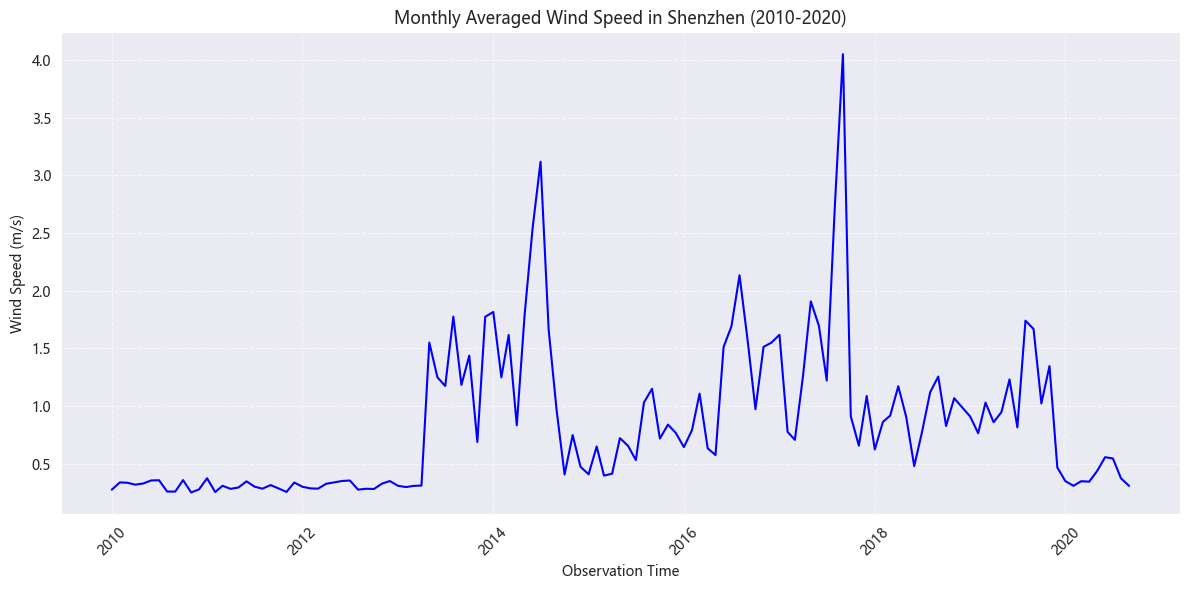

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

df = pd.read_csv('2281305.csv', low_memory=False)
df[['WindDir', 'WindDirQC', 'WindSpdType', 'WindSpd', 'WindSpdQC']] = df['WND'].str.split(',', n=4, expand=True)

df['WindSpd'] = pd.to_numeric(df['WindSpd'], errors='coerce') / 10
df['WindSpd'] = pd.to_numeric(df['WindSpd'], errors='coerce') / 10
df['DATE'] = pd.to_datetime(df['DATE'])

# 筛选2010-2020年的数据
df = df[(df['DATE'] >= datetime.datetime(2010, 1, 1)) & (df['DATE'] <= datetime.datetime(2020, 12, 31))]

# 3. 按月份聚合计算平均风速
df['YearMonth'] = df['DATE'].dt.to_period('M')  # 生成年月周期
monthly_avg_wind = df.groupby('YearMonth')['WindSpd'].mean().reset_index()

# 转换Period类型为datetime以便绘图
monthly_avg_wind['YearMonth'] = monthly_avg_wind['YearMonth'].dt.to_timestamp()
# 4. 绘制月平均风速趋势图
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_wind['YearMonth'], monthly_avg_wind['WindSpd'], color='blue', linewidth=1.5)
plt.title('Monthly Averaged Wind Speed in Shenzhen (2010-2020)')
plt.xlabel('Observation Time')
plt.ylabel('Wind Speed (m/s)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

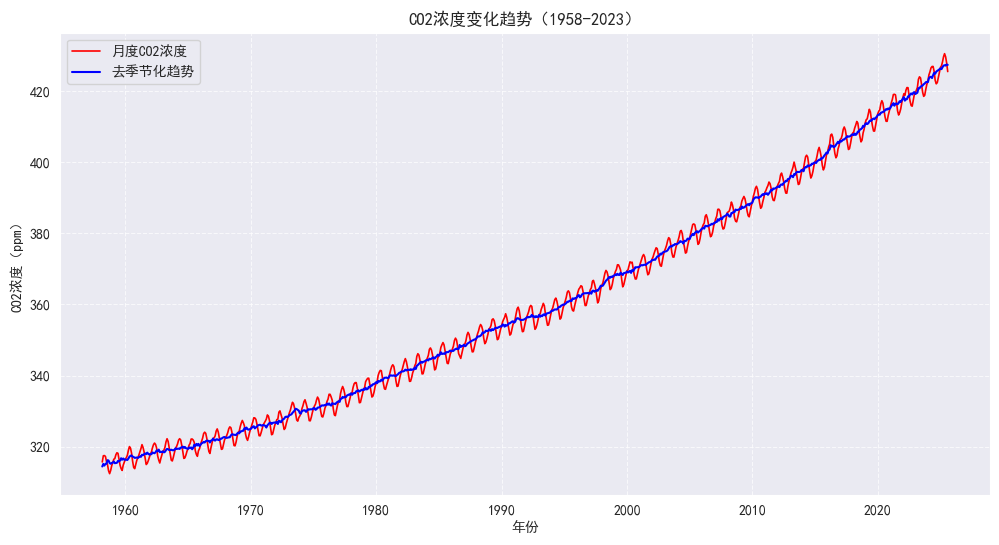

1. 描述性统计：
count    810.00
mean     360.36
std       32.68
min      312.42
25%      330.80
50%      355.79
75%      386.32
max      430.51
Name: co2, dtype: float64

2. 近10年平均CO2浓度：
year
2016    404.41
2017    406.76
2018    408.72
2019    411.65
2020    414.21
2021    416.41
2022    418.53
2023    421.08
2024    424.60
2025    428.12
Name: co2, dtype: float64

3. 长期趋势：每10年CO2浓度上升 16.55 ppm

4. 极值记录：
   最高浓度：430.51 ppm（2025-05）
   最低浓度：312.42 ppm（1958-10）

5. 各月份平均CO2浓度：
   1月：360.57 ppm
   2月：361.35 ppm
   3月：361.51 ppm
   4月：362.81 ppm
   5月：363.39 ppm
   6月：362.84 ppm
   7月：361.30 ppm
   8月：359.28 ppm
   9月：356.75 ppm
   10月：356.81 ppm
   11月：358.16 ppm
   12月：359.48 ppm


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

local_file_path = "D:\\work\\py\\co2_mm_mlo.csv"

df = pd.read_csv(
    local_file_path,
    skiprows=40,
    header=0,
    names=["year", "month", "decimal_date", "co2", "deseasonalized", "n_days", "sdev", "uncertainty"]
)
df = df.replace([-9.99, -0.99], np.nan)
df = df.dropna(subset=["co2"])

df["date"] = pd.to_datetime(
    df[["year", "month"]].assign(day=1)
)
df = df.set_index("date")

plt.figure(figsize=(12, 6))
plt.plot(df.index, df["co2"], color="red", linewidth=1.2, label="月度CO2浓度")
plt.plot(df.index, df["deseasonalized"], color="blue", linewidth=1.5, label="去季节化趋势")
plt.title("CO2浓度变化趋势（1958-2023）")
plt.xlabel("年份")
plt.ylabel("CO2浓度（ppm）")
plt.legend()
plt.grid(linestyle="--", alpha=0.7)
plt.show()

desc_stats = df["co2"].describe()
print("1. 描述性统计：")
print(desc_stats.round(2))

df["year"] = df.index.year
annual_mean = df.groupby("year")["co2"].mean()
print("\n2. 近10年平均CO2浓度：")
print(annual_mean.tail(10).round(2))

x = np.arange(len(df))
y = df["co2"].values
slope, intercept = np.polyfit(x, y, 1)
print(f"\n3. 长期趋势：每10年CO2浓度上升 {slope*120:.2f} ppm")

max_co2 = df["co2"].max()
max_date = df[df["co2"] == max_co2].index[0].strftime("%Y-%m")
min_co2 = df["co2"].min()
min_date = df[df["co2"] == min_co2].index[0].strftime("%Y-%m")
print(f"\n4. 极值记录：")
print(f"   最高浓度：{max_co2:.2f} ppm（{max_date}）")
print(f"   最低浓度：{min_co2:.2f} ppm（{min_date}）")

df["month"] = df.index.month
monthly_avg = df.groupby("month")["co2"].mean()
print("\n5. 各月份平均CO2浓度：")
for month, avg in monthly_avg.items():
    print(f"   {month}月：{avg:.2f} ppm")